# Mini Project 4: Delta and Sigma Hedging under Stochastic Volatility

**Erdös Institute – Introduction to Quantitative Methods in Finance (2025)**

In this project, we explore the impact of time-varying volatility on delta hedging performance. We implement and compare:
- Delta-only hedging strategies
- Sigma (vega) hedging using call spreads 

Under both 

- A toy stochastic volatility model with discrete sigma values
- The Heston stochastic volatility model

---


In [2]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%run functions.py

## Toy Model: Simulating Stock Paths with Time-Varying Volatility

We simulate geometric Brownian motion with a non-constant volatility. At each step:
- 50% chance: σ = 0.2
- 30% chance: σ = 0.3
- 20% chance: σ = 0.45


In [3]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

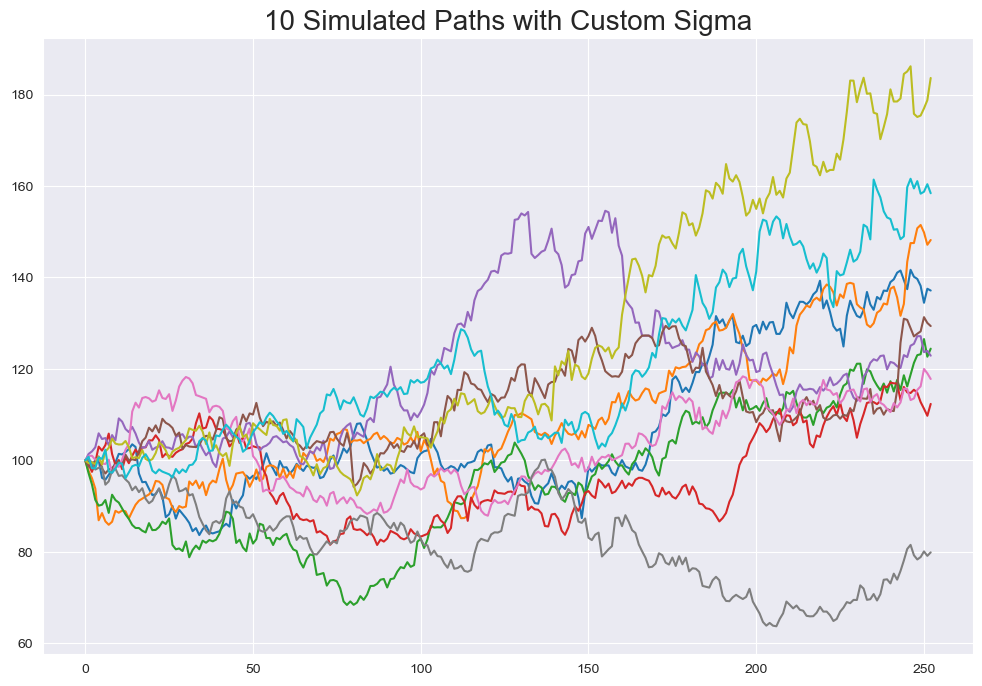

In [182]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 10
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

## Toy Model: Delta Hedging Performance

We simulate stock paths with randomly changing volatility at each step. To hedge, we recalculate deltas using the Black-Scholes formula with an estimated volatility typically the average across simulations at each hedge step.

This reflects a trader adjusting their hedge based on updated volatility estimates, not the true underlying process.


In [4]:
def bs_MC_call_custom_sigma(S0, K, t, r, mu=0, n_sims=2500, n_hedges=50, delta_sims=250):
    """Monte-Carlo simulation of a call option using custom stochastic volatility and Delta hedging."""
    
    dt = t / n_hedges
    noise = np.random.normal(0, 1, (n_sims, n_hedges))
    
    # Custom stochastic volatility for each path and time step
    sigma = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2], size=(n_sims, n_hedges))
    
    # Generate log returns and stock paths
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)

    # Simulate discounted call payoffs
    path_end_points = paths[:, -1]
    call_payouts = np.maximum(path_end_points - K, 0) * np.exp(-r * t)

    # Hedging - calculate stock profits
    stock_profits = []

    # Initial delta hedge (S0)
    delta_start = bs_MC_call_delta(S0, K, np.mean(sigma[:, 0]), t, r, delta_sims)
    first_profits = (paths[:, 0] - S0 * np.exp(r * dt)) * delta_start * np.exp(-r * dt)
    stock_profits.append(first_profits)

    # Subsequent steps
    for i in range(1, n_hedges):
        S_prev = paths[:, i - 1]
        S_next = paths[:, i]
        tte = t - i * dt

        # Use *average* sigma at this hedge step across all paths
        deltas = bs_MC_call_delta_array(S_prev, K, sigma[:, i], tte, r, delta_sims)
        
        profits = (S_next - S_prev * np.exp(r * dt)) * deltas * np.exp(-r * dt * i)
        stock_profits.append(profits)

    total_profit = np.sum(stock_profits, axis=0)
    profits_hedged = call_payouts - total_profit

    return profits_hedged

### Exploring Hedge Frequency

To study how rebalancing frequency affects hedging performance, we simulate delta hedging using 7 different hedge intervals:

- 1, 2, 5, 10, 25, 50, and 252 times per year

This ranges from a single hedge at inception to daily rebalancing, reflecting practical constraints faced by traders.


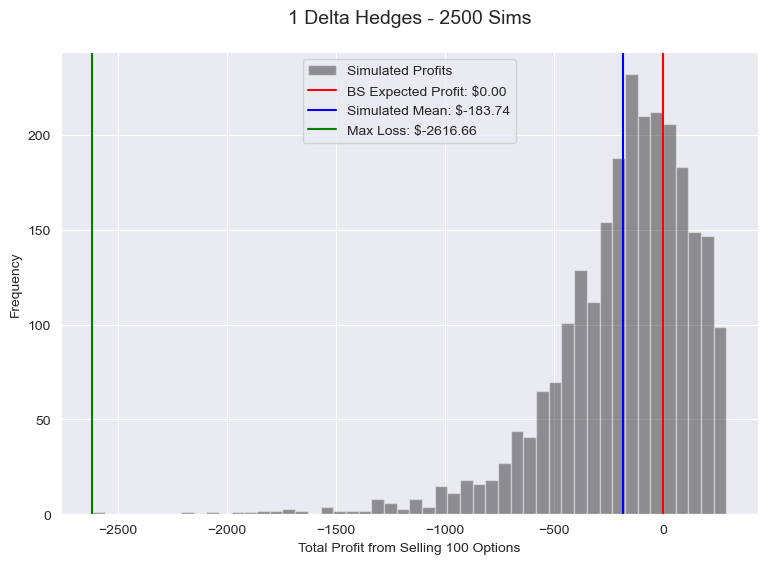

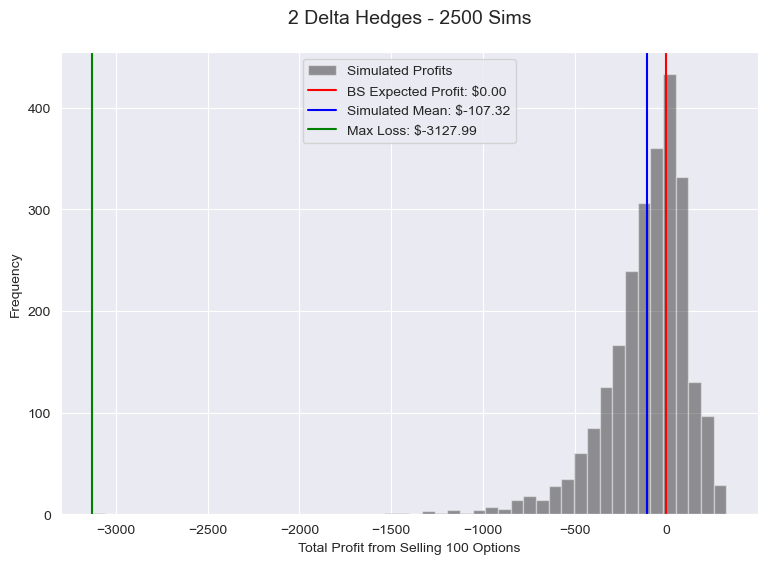

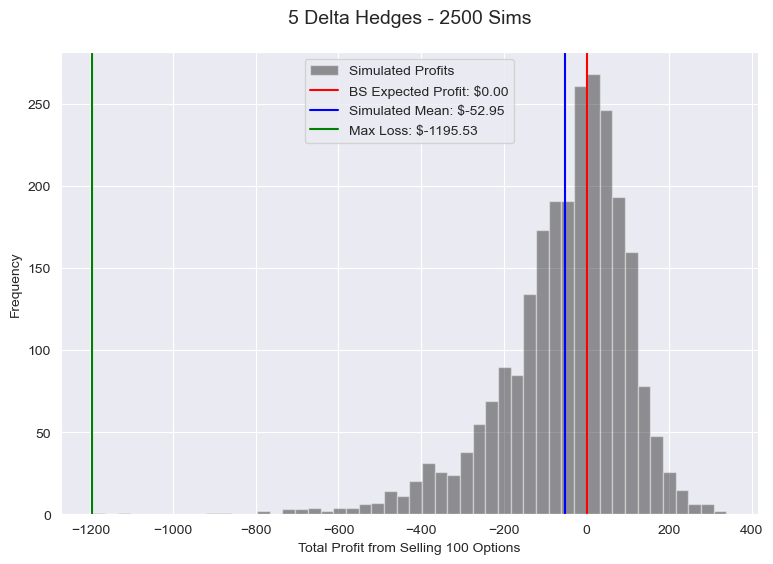

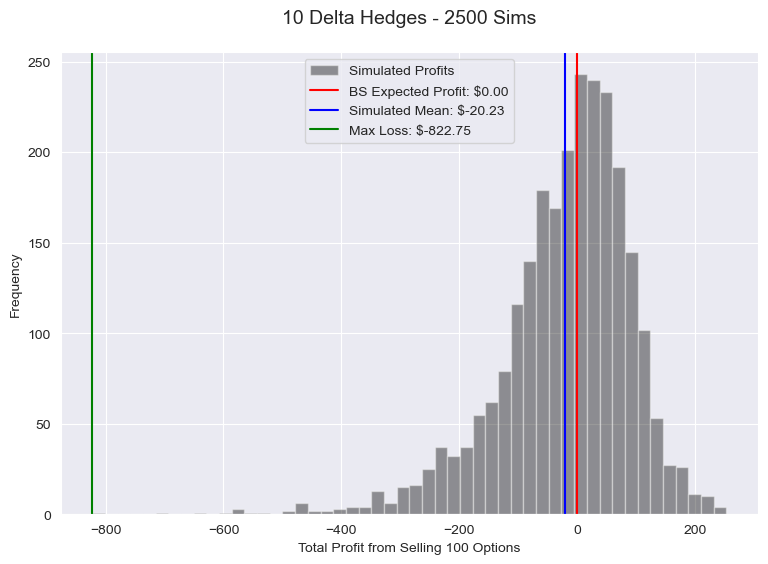

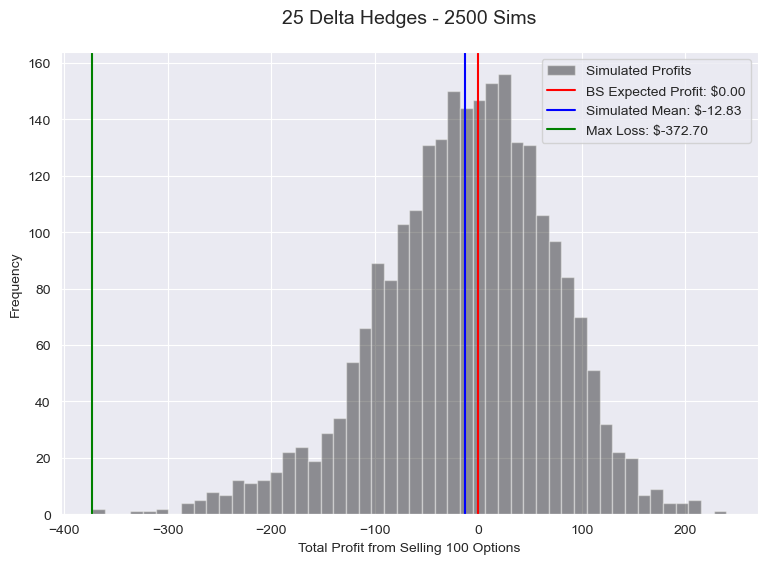

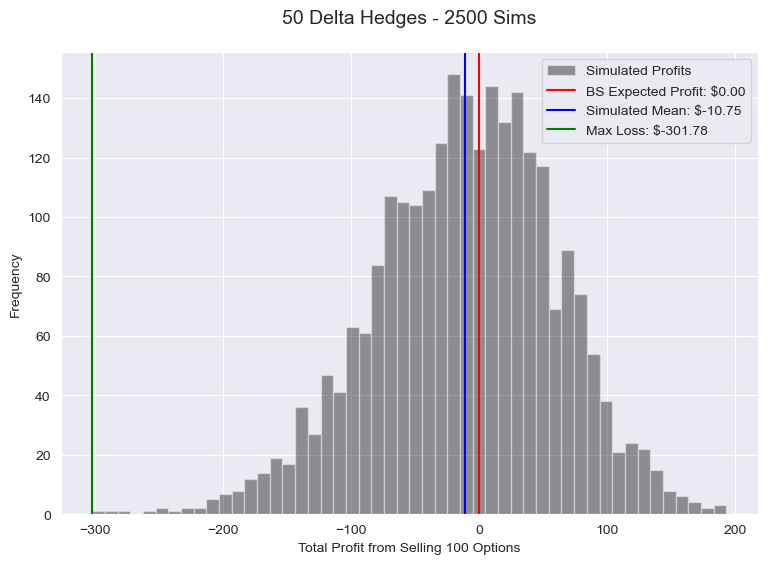

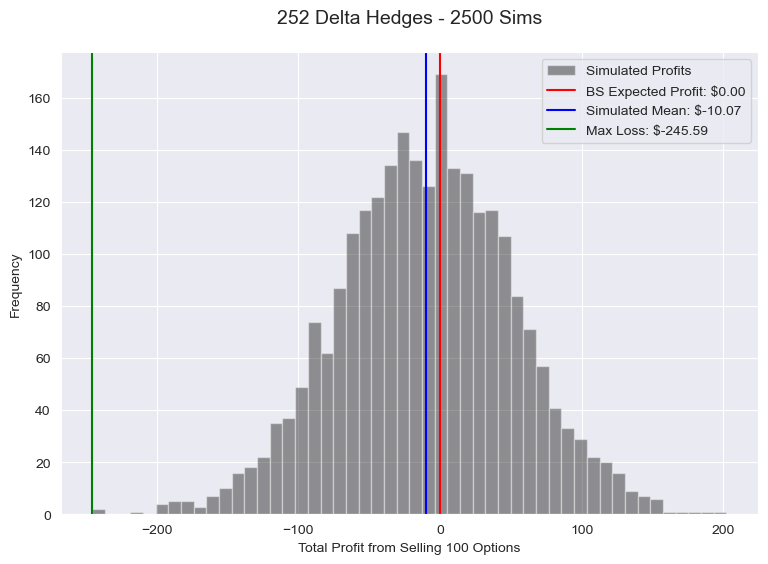

In [186]:
# Parameters
S0 = 35
K = 32
t = 1
r = 0.04
mu = 0.35
n_sims = 2500
delta_sims = 250
num_options = 100

# Use implied vol > expected vol to simulate overpricing
implied_sigma = 0.28  # overpriced assumption
premium = bs_call(S0, K, implied_sigma, t, r)

# Expected (mean) sigma from your custom distribution
fair_sigma = 0.2 * 0.5 + 0.3 * 0.3 + 0.45 * 0.2
bs_price = bs_call(S0, K, fair_sigma, t, r)

# Different hedge frequencies
hedging_numbers = [1, 2, 5, 10, 25, 50, 252]

for n_hedges in hedging_numbers:
    # Simulate P&L for each hedge frequency
    call_costs = bs_MC_call_custom_sigma(S0, K, t, r, mu, n_sims, n_hedges, delta_sims)
    profits_hedged = num_options * (premium - call_costs)

    # Plot
    plt.figure(figsize=(9,6))
    plt.hist(profits_hedged, bins=50, alpha=0.4, color='black', label='Simulated Profits')

    plt.axvline(num_options * (premium - bs_price), color='red', label=f'BS Expected Profit: ${num_options*(premium - bs_price):.2f}')
    plt.axvline(np.mean(profits_hedged), color='blue', label=f'Simulated Mean: ${np.mean(profits_hedged):.2f}')
    plt.axvline(np.min(profits_hedged), color='green', label=f'Max Loss: ${np.min(profits_hedged):.2f}')

    plt.title(f'{n_hedges} Delta Hedges - {n_sims} Sims\n', size=14)
    plt.xlabel("Total Profit from Selling 100 Options")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


### Takeaways from Delta Hedging Frequency Analysis

- **More frequent hedging reduces average loss**: The simulated mean profit improves significantly as the number of hedge steps increases from 1 to 252.
- **Hedging error variance decreases**: The distribution tightens, with narrower spreads and reduced left-tail risk (i.e., smaller worst-case losses).
- **Tail risk drops sharply**: Max losses improve from over -$3000 (1–2 hedges) to about -$250 (252 hedges).
- **Convergence to BS expectation**: With daily hedging (252 steps), the mean P&L approaches the Black-Scholes expected profit of \$0, indicating minimal hedging error under stochastic volatility.
- **Diminishing returns**: Beyond 25–50 hedge steps, additional hedging frequency offers smaller marginal improvement in risk reduction.

This highlights the importance of hedge frequency — particularly under volatile or uncertain conditions — while balancing it against transaction costs in real-world trading.


## Toy Model: Comparing Delta and Sigma Hedging Strategies

In this section, we compare the performance of two hedging strategies applied under a discrete stochastic volatility environment:

1. **Delta-only hedging**: Uses Black-Scholes delta to hedge exposure to price changes at each time step, but does not address changing volatility.

2. **Sigma (vega) hedging**: In addition to delta hedging, this strategy uses a static call spread (short one call, long another with a higher strike) to reduce exposure to volatility shocks.

Both strategies begin by selling a call option that is overpriced — priced using an implied volatility of 0.28, while the actual volatility is sampled from the following distribution:
- 50% chance: σ = 0.2  
- 30% chance: σ = 0.3  
- 20% chance: σ = 0.45  


In [187]:
def bs_MC_call_sigma_hedged(S0, K_short, K_long, t, r, mu=0.0, n_sims=2500, n_hedges=50, delta_sims=250):
    """
    Simulate a sigma-neutral (vega-hedged) strategy by selling one call and buying another,
    and delta-hedging the net position under a custom sigma path.
    
    Inputs:
    - S0: initial stock price
    - K_short: strike of call you sell
    - K_long: strike of call you buy (to hedge vega)
    - t: time to maturity
    - r: risk-free rate
    - mu: stock drift
    - n_sims: number of simulations
    - n_hedges: delta hedge steps
    - delta_sims: finite difference delta estimation points
    
    Returns:
    - np.array of hedged P&L outcomes from the strategy
    """
    
    dt = t / n_hedges
    noise = np.random.normal(0, 1, (n_sims, n_hedges))
    sigma = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2], size=(n_sims, n_hedges))
    
    # Simulate stock paths
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)

    # Payoffs
    ST = paths[:, -1]
    call_short = np.maximum(ST - K_short, 0)
    call_long = np.maximum(ST - K_long, 0)
    net_payoff = call_short - call_long
    discounted_payoff = net_payoff * np.exp(-r * t)
    
    # Delta hedging of net call position
    stock_profits = []

    # Initial deltas
    delta_short = bs_MC_call_delta(S0, K_short, np.mean(sigma[:, 0]), t, r, delta_sims)
    delta_long = bs_MC_call_delta(S0, K_long, np.mean(sigma[:, 0]), t, r, delta_sims)
    delta_net = delta_short - delta_long
    
    first_profits = (paths[:, 0] - S0 * np.exp(r * dt)) * delta_net * np.exp(-r * dt)
    stock_profits.append(first_profits)

    for i in range(1, n_hedges):
        S_prev = paths[:, i - 1]
        S_next = paths[:, i]
        tte = t - i * dt

        d_short = bs_MC_call_delta_array(S_prev, K_short, sigma[:, i], tte, r, delta_sims)
        d_long = bs_MC_call_delta_array(S_prev, K_long, sigma[:, i], tte, r, delta_sims)
        d_net = d_short - d_long

        profit = (S_next - S_prev * np.exp(r * dt)) * d_net * np.exp(-r * dt * i)
        stock_profits.append(profit)

    total_hedge_profit = np.sum(stock_profits, axis=0)

    # Premiums
    implied_sigma = 0.28
    premium_short = bs_call(S0, K_short, implied_sigma, t, r)
    premium_long = bs_call(S0, K_long, implied_sigma, t, r)
    net_premium = premium_short - premium_long

    total_profit = net_premium - discounted_payoff + total_hedge_profit

    return total_profit


Simulating Delta-only Hedging...
Simulating Sigma Hedging (Call Spread)...


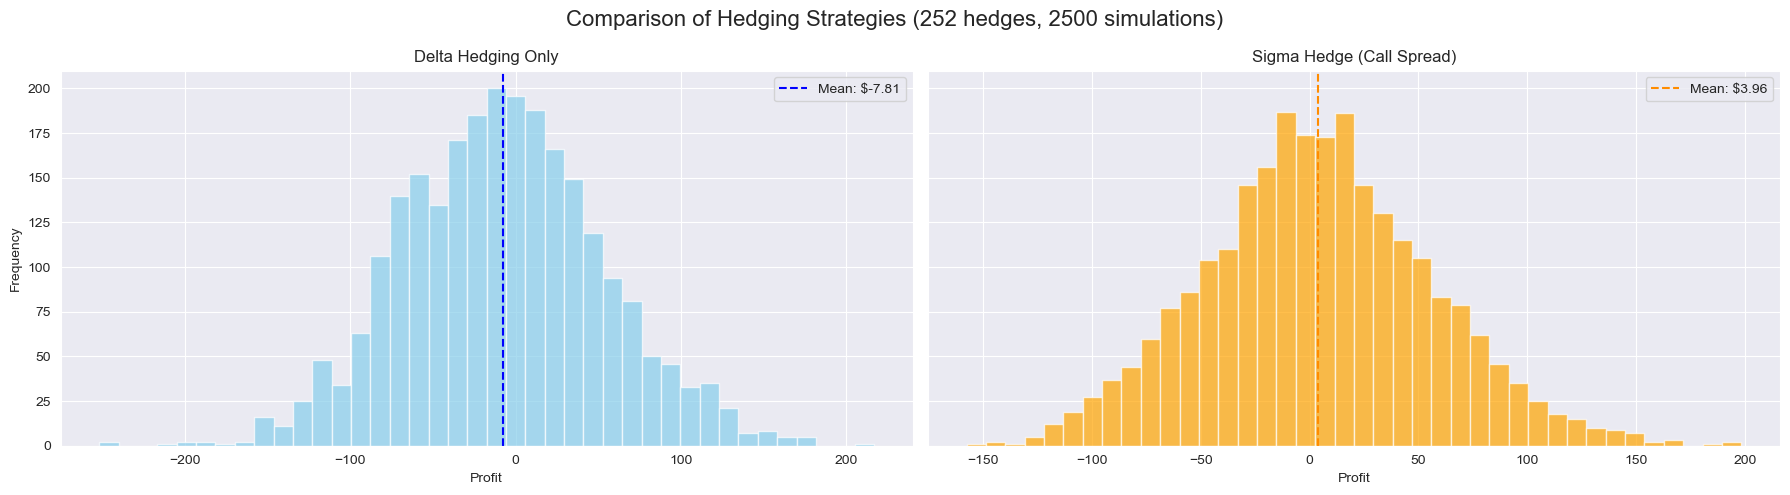

 Delta-only
  Mean       : $-7.81
  Std Dev    : $60.84
  Max Profit : $217.03
  Max Loss   : $-252.01

 Sigma Hedge
  Mean       : $3.96
  Std Dev    : $52.32
  Max Profit : $198.21
  Max Loss   : $-157.47



In [191]:
# Set parameters
S0 = 35
K_short = 32
K_long = 34
t = 1
r = 0.04
mu = 0.35
n_sims = 2500
n_hedges = 252
delta_sims = 250
num_options = 100
implied_sigma = 0.28

# Premium for delta-only strategy (no hedge option cost)
premium = bs_call(S0, K_short, implied_sigma, t, r)

# Run simulations
print("Simulating Delta-only Hedging...")
pnl_delta = num_options * (premium - bs_MC_call_custom_sigma(S0, K_short, t, r, mu, n_sims, n_hedges, delta_sims))

print("Simulating Sigma Hedging (Call Spread)...")
pnl_static = num_options * bs_MC_call_sigma_hedged(S0, K_short, K_long, t, r, mu, n_sims, n_hedges, delta_sims)

# Plot results: side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

# Delta-only
axes[0].hist(pnl_delta, bins=40, color='skyblue', alpha=0.7)
axes[0].axvline(np.mean(pnl_delta), color='blue', linestyle='--', label=f'Mean: ${np.mean(pnl_delta):.2f}')
axes[0].set_title("Delta Hedging Only")
axes[0].set_xlabel("Profit")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Sigma hedge
axes[1].hist(pnl_static, bins=40, color='orange', alpha=0.7)
axes[1].axvline(np.mean(pnl_static), color='darkorange', linestyle='--', label=f'Mean: ${np.mean(pnl_static):.2f}')
axes[1].set_title("Sigma Hedge (Call Spread)")
axes[1].set_xlabel("Profit")
axes[1].legend()

plt.suptitle(f"Comparison of Hedging Strategies ({n_hedges} hedges, {n_sims} simulations)", fontsize=16)
plt.tight_layout()
plt.show()

# Print summary
def summarize(label, pnl):
    print(f" {label}")
    print(f"  Mean       : ${np.mean(pnl):.2f}")
    print(f"  Std Dev    : ${np.std(pnl):.2f}")
    print(f"  Max Profit : ${np.max(pnl):.2f}")
    print(f"  Max Loss   : ${np.min(pnl):.2f}")
    print("")

summarize("Delta-only", pnl_delta)
summarize("Sigma Hedge", pnl_static)


### Results Summary

After running 2500 simulations of each strategy over 252 hedge steps, we observe the following:

| Metric         | Delta-Only       | Sigma Hedge       |
|----------------|------------------|-------------------|
| **Mean P&L**   | -\$7.81          | **+\$3.96**       |
| **Std Dev**    | \$60.84          | **\$52.32**       |
| **Max Profit** | \$217.03         | \$198.21          |
| **Max Loss**   | -\$252.01        | **-\$157.47**     |

- Both strategies sell the same call for a premium based on implied volatility of 0.28.
- However, the **true average volatility** is only ~0.275, meaning the option is **theoretically overpriced**.
- In theory, both strategies should yield some positive expected profit — but only the **sigma hedge consistently realizes that**.


### Why Does Sigma Hedging Outperform?

1. **Delta only hedging can't adjust for volatility shocks**  
   - Even though it rebalances delta each step, it only accounts for price changes , not shifts in volatility.
   - This leads to **replication error** when realized volatility differs from assumed or estimated values.

2. **Sigma hedging offsets volatility risk**  
   - By buying a second call (higher strike), the strategy becomes **vega neutral** at inception.
   - As volatility changes, the long call offsets part of the price drift due to vol  **reducing both variance and left-tail loss**.

3. **Theoretical edge is better captured**  
   - The trader collects a premium based on high implied volatility (0.28).
   - Sigma hedging helps retain more of this theoretical profit by minimizing mishedging losses.

Thus, while delta hedging alone already performs reasonably well, adding a **simple static vega hedge** (call spread) improves the **mean profit**, reduces **standard deviation**, and cuts down **worst case losses**.


### Conclusion: Toy Model Hedging Comparison

The sigma hedging strategy clearly outperforms delta only hedging under the toy stochastic volatility model. This demonstrates that:

- **Volatility risk matters** in realistic markets
- Even basic sigma hedging (like a call spread) can significantly improve hedging effectiveness
- More frequent rebalancing helps , but combining delta + sigma hedging is most robust under uncertain volatility

This insight justifies why traders often use **multi dimensional hedging (delta, vega, gamma)** in practice , especially in environments where implied and realized volatilities diverge.


## Heston Model: Realistic Volatility Simulation

We now simulate stock paths under the Heston model, where volatility evolves stochastically over time. This allows us to study delta and sigma hedging under more realistic market conditions.


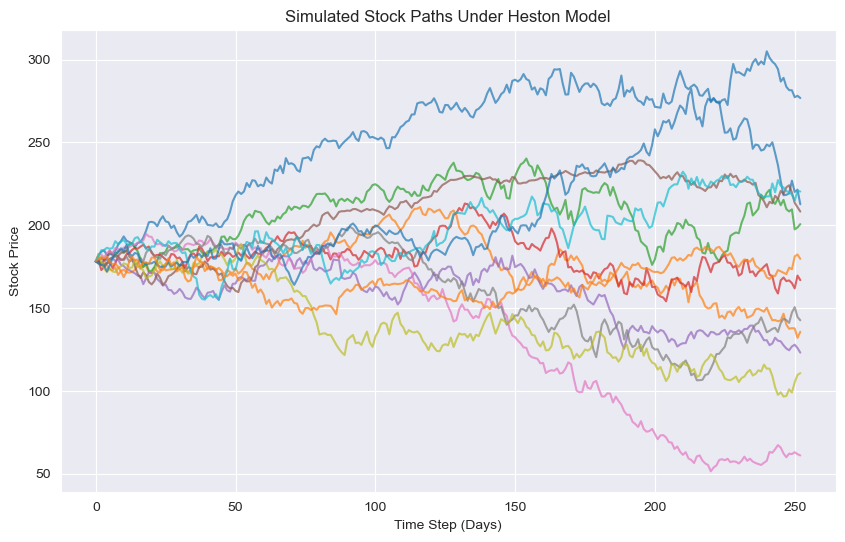

In [97]:
### Simulated Historical volatilites of stock path under Heston model.


#Heston parameters
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 2500 #Number of simulations

mu = .034 #Excess drift of log returns


#Strike

K = 185



paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, False)

plt.figure(figsize=(10, 6))
for i in range(12):  # Plot 10 sample paths
    plt.plot(paths[i], alpha=0.7)
plt.title("Simulated Stock Paths Under Heston Model")
plt.xlabel("Time Step (Days)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

## Heston Model: Delta Hedging Performance

We apply a Black-Scholes-based delta hedging strategy to Heston paths and compare simulated hedged profits to closed-form Heston pricing.


Monte-Carlo Simulated value of Call Option, Heston Model: $18.69 with standard error 0.109780.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.53.
--------------------------------------------------
--------------------------------------------------


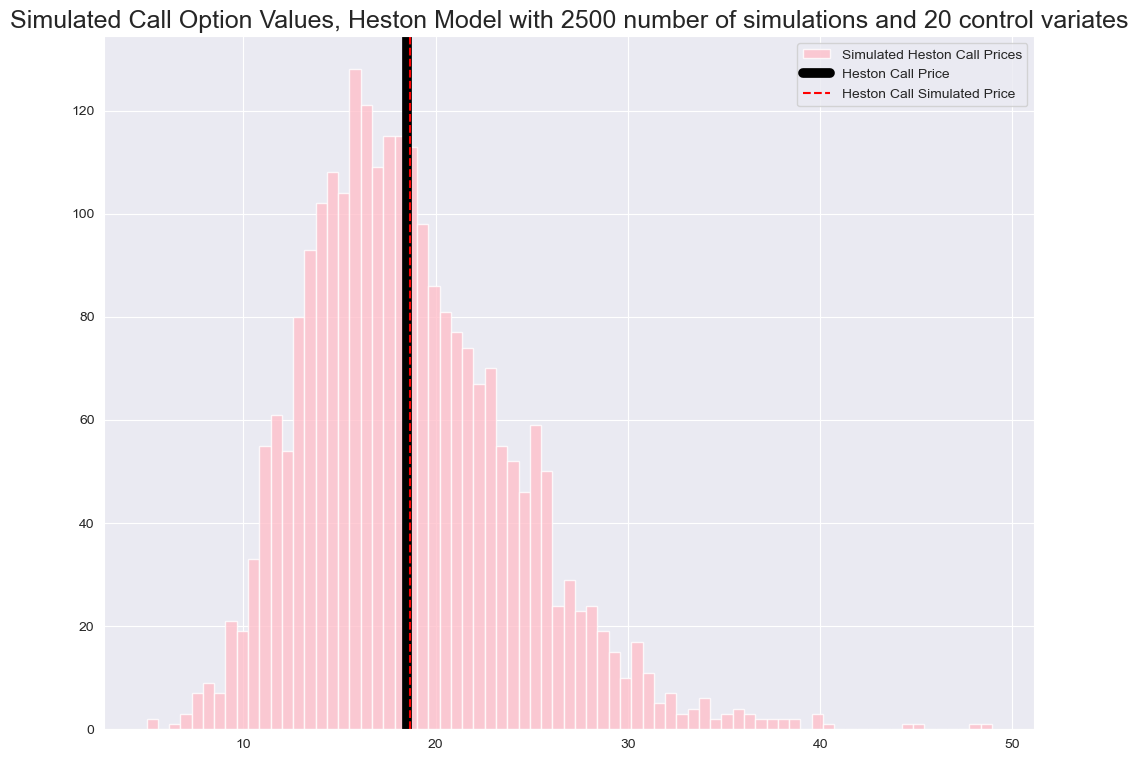

In [13]:
#Use Monte-Carlo methods to simulate price of call option under Heston-Model.
#Compare estimate provided by faster method of numeric integration.

### Visual of stock paths measure simulated through the Heston model


#Heston parameters
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .46 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.7 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

n_steps = 20 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 2500 #Number of simulations

mu = .034 #Excess drift of log returns


#Strike

K = 185



#Monte-Carlo Simulation
call_payouts_hedged = heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

heston_call_sim = np.mean(np.mean(call_payouts_hedged))

heston_std_err = np.std(call_payouts_hedged)/np.sqrt(n_sims)

heston_call_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)


print(f'Monte-Carlo Simulated value of Call Option, Heston Model: ${heston_call_sim:.2f}\
 with standard error {heston_std_err:.6f}.')


print('-----'*10)
print('-----'*10)


print(f'Actual value of call option under Heston model assumption: ${heston_call_price:.2f}.')


print('-----'*10)
print('-----'*10)


plt.figure(figsize = (12,9))

plt.hist(call_payouts_hedged, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Call Prices')
plt.axvline(heston_call_price, label = 'Heston Call Price',color = 'black', lw = '7', alpha = 1)
plt.axvline(heston_call_sim, label = 'Heston Call Simulated Price', color = 'red', ls = '--')



plt.title(f'Simulated Call Option Values, Heston Model with {n_sims} number of simulations and {n_steps} control variates', size = 18)



plt.legend()

plt.show()


## Heston Model: Sigma + Delta Hedging

We try to extend the hedging strategy by including vega hedging. Using a second option, we attempt to explore a way neutralize the portfolio's exposure to changes in volatility (sigma). Similar to the toy model, we try to compare the two strategies in this more complicated setting.


In [14]:
def heston_call_MC_sigma_hedged(S0, K, v0, r, t, n_steps,
                                 kappa, theta, xi, rho,
                                 K_hedge=None, mu=0, n_sims=2500):
    """
    Monte Carlo Simulation of Heston Call Option using both Delta and Vega (Sigma) hedging.
    Uses Black-Scholes Greeks as control variates.

    Returns:
        np.array of sigma-hedged call prices
    """

    dt = t / n_steps
    paths, vols = heston_path_sim(S0, v0, r, t, n_steps,
                                   kappa, theta, xi, rho,
                                   n_sims=n_sims, mu=mu, return_vol=True)

    call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

    stock_pnls = []
    option_pnls = []

    for i in range(1, n_steps + 1):
        St_prev = paths[:, i - 1]
        St = paths[:, i]

        vt_prev = vols[:, i - 1]
        vt_next = vols[:, i]
        sigma_prev = np.clip(np.sqrt(np.maximum(vt_prev, 0)), 1e-4, 2.0)
        sigma_next = np.clip(np.sqrt(np.maximum(vt_next, 0)), 1e-4, 2.0)

        t_remain_prev = t - (i - 1) * dt
        t_remain_next = t - i * dt

        # Delta (BS-based) on previous step
        deltas = bs_call_delta(St_prev, K, sigma_prev, t_remain_prev, r)

        # Vega-based hedge ratios
        vegas_target = bs_vega(St_prev, K, sigma_prev, t_remain_prev, r)
        vegas_hedge = bs_vega(St_prev, K_hedge, sigma_prev, t_remain_prev, r)
        vega_ratio = np.divide(vegas_target, vegas_hedge, out=np.zeros_like(vegas_target), where=vegas_hedge != 0)
        vega_ratio = np.clip(vega_ratio, -10, 10)

        # Hedge option prices (prev and next step)
        hedge_price_start = bs_call(St_prev, K_hedge, sigma_prev, t_remain_prev, r)
        hedge_price_end = bs_call(St, K_hedge, sigma_next, t_remain_next, r)

        # P&L calculations
        stock_pnl = (St - St_prev * np.exp(r * dt)) * deltas * np.exp(-r * i * dt)
        option_pnl = (hedge_price_end - hedge_price_start * np.exp(r * dt)) * vega_ratio * np.exp(-r * i * dt)

        stock_pnls.append(stock_pnl)
        option_pnls.append(option_pnl)

    total_stock_pnl = np.sum(stock_pnls, axis=0)
    total_option_pnl = np.sum(option_pnls, axis=0)

    hedged_values = call_payouts - total_stock_pnl - total_option_pnl

    return hedged_values


Heston MC Sigma-Hedged Price: $18.51 ± 0.1623
Heston Closed-Form Price: $18.53


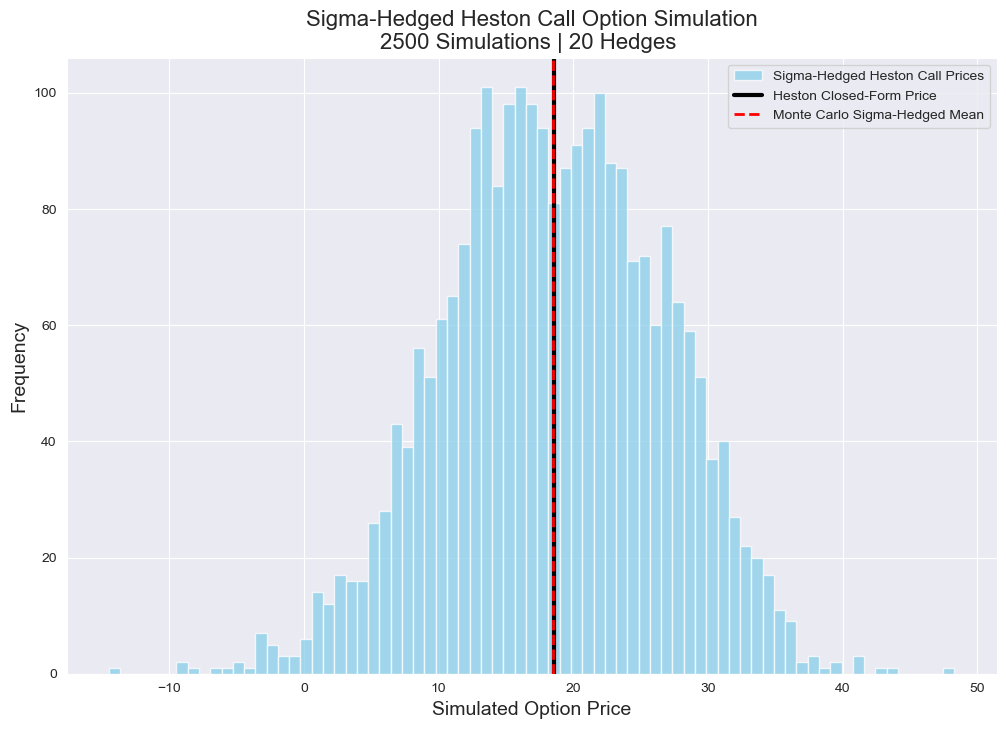

In [31]:
# Run the simulation

sigma_hedged_vals = heston_call_MC_sigma_hedged(
    S0, K, v0, r, t, n_steps, kappa, theta, xi, rho,
    K_hedge=K+56, mu=mu, n_sims=n_sims
)

# Compute statistics
mean_sigma_hedged = np.mean(sigma_hedged_vals)
std_err_sigma_hedged = np.std(sigma_hedged_vals) / np.sqrt(n_sims)
heston_price_analytical = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)

# Print results
print(f"Heston MC Sigma-Hedged Price: ${mean_sigma_hedged:.2f} ± {std_err_sigma_hedged:.4f}")
print(f"Heston Closed-Form Price: ${heston_price_analytical:.2f}")

# Plot histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.hist(sigma_hedged_vals, bins=75, alpha=0.75, color='skyblue', label='Sigma-Hedged Heston Call Prices')

# Overlay vertical lines
plt.axvline(heston_price_analytical, color='black', linestyle='-', lw=3, label='Heston Closed-Form Price')
plt.axvline(mean_sigma_hedged, color='red', linestyle='--', lw=2, label='Monte Carlo Sigma-Hedged Mean')

# Titles and labels
plt.title(f"Sigma-Hedged Heston Call Option Simulation\n{n_sims} Simulations | {n_steps} Hedges ", fontsize=16)
plt.xlabel("Simulated Option Price", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


### Heston Simulation: Delta vs. Sigma Hedging

- **Delta Hedging**:  
  Uses Black-Scholes deltas to hedge exposure to price movements. It performs well, producing a stable estimate slightly above the true Heston price.

- **Sigma Hedging**:  
  Adds a vega hedge using a second call option. This brings the estimated price even closer to the true Heston value.

- **Conclusion**:  
  Both strategies are effective under the Heston model. Sigma hedging improves pricing accuracy marginally


### Final Summary

- Delta hedging works well when volatility is stable or changes slowly.
- Sigma hedging (e.g. call spreads) improves performance under variable volatility.
- The more realistic Heston model confirms that while sigma hedging increases implementation complexity, it can marginally improve pricing precision.
- Effective hedging strategies must adapt to volatility dynamics : traders benefit from incorporating both delta and vega hedges.

This project highlights the limitations of delta hedging under stochastic volatility and the potential benefits of extending to multi dimensional hedging strategies.
